In [1]:
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Data

## NYT sentiment

In [2]:
# company names - current
comp_names = ['21st-Century-Fox', 'AT&T', 'CBS', 'Comcast', 'Verizon']

In [3]:
sent_nyt = dict()

for comp in comp_names:
    f = glob.glob('GIT_repo/NYT_sentiment_data/'+comp+'*.csv')
    df = pd.read_csv(f[0])
    df = df.drop(['Unnamed: 0', 'level_0', 'index'], axis=1)
    df = df.drop(['Modal', 'Negative', 'Positive', 'Uncertainty', 
                  'Litigious', 'Constraining', 'Superfluous',
                  'Interesting', 'Doc_length', 'Positive_score'], axis=1)
    # change dta to datetime 
    df.date = pd.to_datetime(df.date)
    # set index to date
    df = df.set_index('date')
    
    bub = list(df.columns)
    bub += ['date']
    df_temp = pd.DataFrame([[0.5]*len(df.columns) + [pd.to_datetime('2018-12-03')]], columns=bub)
    df_temp = df_temp.set_index('date')
    df = df.append(df_temp)
    
    # resample daily take mean if more news in a day, forward fill
    df = df.resample('1D').mean().ffill()
    
    # rolling average
    for col in df.columns:
        df['roll_'+col] = df[col].rolling(window=60, min_periods=1).mean()
    sent_nyt[comp] = df

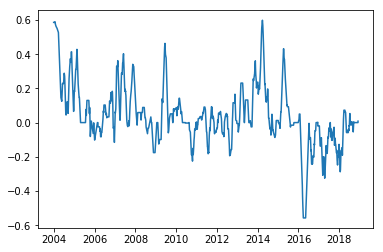

In [4]:
plt.plot(sent_nyt['21st-Century-Fox'].roll_compounds_head)
plt.show()

## SEC Sentiment

In [5]:
sec_names = ['fox', 'att', 'cbs', 'comcast', 'verizon']
sec_map = dict(zip(sec_names, comp_names))
print(sec_map)

sent_sec = dict()

for sec_comp in sec_names:
    df = pd.read_csv('sentiment/'+sec_comp+'_sentiment.csv')
    df = df.drop(['Unnamed: 0', 'Sentiment'], axis=1)
    df = df.sort_values(by=['findexdate'])
    df.findexdate = pd.to_datetime(df.findexdate)
    df = df.set_index('findexdate')
    
    bub = list(df.columns)
    bub += ['date']
    df_temp = pd.DataFrame([[0.5]*len(df.columns) + [pd.to_datetime('2018-12-03')]], columns=bub)
    df_temp = df_temp.set_index('date')
    df = df.append(df_temp)
        
    # resample daily
    df = df.resample('1D').mean().ffill()
    
#     df = df.resample('1D', how = 'mean', fill_method='ffill')

    col_map = dict()
    for col in df.columns:
        col_map[col] = 'SEC_' + col

    df = df.rename(index=str, columns=col_map)

    # calc rolling avg
    for col in df.columns:
        df['roll_'+col] = df[col].rolling(window=60, min_periods=1).mean()
        
    sent_sec[sec_map[sec_comp]] = df
    sent_nyt[sec_map[sec_comp]] = sent_nyt[sec_map[sec_comp]].join(df, on=None, how='left')
    sent_nyt[sec_map[sec_comp]] = sent_nyt[sec_map[sec_comp]].fillna(value=0)

{'fox': '21st-Century-Fox', 'att': 'AT&T', 'cbs': 'CBS', 'comcast': 'Comcast', 'verizon': 'Verizon'}


## Stock price

In [6]:
import fix_yahoo_finance as yf
import datetime as dt

# stock prices - from Yahoo finance
tickers = ['FOXA', 'T', 'CBS', 'CMCSA', 'VZ']
start = dt.datetime(1993,1,1)
end = dt.datetime(2018,12,3)
df_stock = yf.download(tickers, start=start, end=end)
print(df_stock.shape, df_stock.dtypes)
# df_stock.tail(3)

[*********************100%***********************]  5 of 5 downloaded
(6529, 30) Open       CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
High       CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
Low        CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
Close      CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
Adj Close  CBS      float64
           CMCSA    float64
           FOXA     float64
           T        float64
           VZ       float64
Volume     CBS      float64
           CMCSA      int64
           FOXA     float64
           T          int64
           VZ         int64
dtype: object


In [7]:
df_open = df_stock['Open']
df_open = df_open.fillna(method='backfill')
df_open = df_open.resample('1D', how = 'mean', fill_method='ffill')
df_open.index = pd.to_datetime(df_open.index)
# df_open

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).mean().ffill()
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
ticker_map = dict(zip(comp_names, tickers))
ticker_map

for comp in comp_names:
    sent_nyt[comp] = sent_nyt[comp].join(df_open[ticker_map[comp]], on=None, how='left')
    sent_nyt[comp] = sent_nyt[comp].rename(index=str, columns={ticker_map[comp]: 'stock_open'})

# SEC categories

In [6]:
df_cat = pd.read_csv('updated_category.csv', sep='|', encoding='utf-8')
df_cat = df_cat.drop(['Unnamed: 0', 'sec_full_path', 'form'], axis=1)

for cik in df_cat.cik.unique():
    df_temp = df_cat[df_cat.cik==cik]
    
    print(cik, df_temp.coname.unique())
    
cik_map = {732712: 'Verizon',
           1166691: 'Comcast',
           813828: 'CBS',
           732717: 'AT&T',
           1308161: '21st-Century-Fox'}

df_cat['comp_name'] = df_cat.cik.map(lambda x: cik_map[x])
df_cat = df_cat.drop(['cik', 'coname'], axis=1)

# change date to datetime obj
df_cat.fdate = pd.to_datetime(df_cat.fdate)

# get dummies for the item categories
dum = pd.get_dummies(df_cat.updated_item_category_splited_v2)
# dum2 = pd.get_dummies(df_cat.coname)

df_cat = pd.concat([df_cat, dum], axis=1)

732712 ['BELL ATLANTIC CORP' 'VERIZON COMMUNICATIONS INC']
1166691 ['COMCAST CORP']
813828 ['VIACOM INC' 'CBS CORP']
732717 ['SOUTHWESTERN BELL CORP' 'SBC COMMUNICATIONS INC' 'AT&T INC.']
1308161 ['NEWS CORP' 'TWENTY-FIRST CENTURY FOX, INC.']


In [7]:
for comp in comp_names:

    df = df_cat[df_cat.comp_name==comp]
    df= df.set_index('fdate')
    
    bub = list(df.columns)
    bub += ['date']
    df_temp = pd.DataFrame([[0.5]*len(df.columns) + [pd.to_datetime('2018-12-03')]], columns=bub)
    df_temp = df_temp.set_index('date')
    df = df.append(df_temp)
        
    # resample daily, forward fill
    df = df.resample('1D').mean().ffill()
    
    sent_nyt[comp] = sent_nyt[comp].join(df, on=None, how='left')
    sent_nyt[comp] = sent_nyt[comp].fillna(value=0)

## Moody's

In [8]:
df_moodys = pd.read_csv('Moodys_new_type.csv')
df_moodys = df_moodys.drop(['Unnamed: 0', "Moody's Rating", 'Watch', 'Type', 'delta'], axis=1)
# df_moodys['Effective Date'] = df_moodys['Effective Date'].map(lambda x: int(x[:4]))
df_moodys['Effective Date'] = pd.to_datetime(df_moodys['Effective Date'])

df_moodys = df_moodys[df_moodys['Effective Date']<pd.to_datetime('2018-09-01')]

df_moodys = df_moodys.reset_index()

print(df_moodys.shape)

name_map = dict(zip(df_moodys.Company.unique(), comp_names))
name_map

(51, 4)


{'21st Century Fox America': '21st-Century-Fox',
 'AT&T Corp': 'AT&T',
 'CBS Corp': 'CBS',
 'Comcast Corp': 'Comcast',
 'Verizon Communications Inc': 'Verizon'}

In [9]:
df_moodys.my_type.value_counts()

same    27
up      14
down    10
Name: my_type, dtype: int64

In [10]:
df_moodys

# augmenting the moodys with days for Jul and Aug for the test set

from datetime import timedelta

start_date = pd.to_datetime('2018-07-01')
end_date = pd.to_datetime('2018-08-31')
num_days = end_date - start_date
num_days = int(num_days.days) + 1

print(num_days)

for comp in df_moodys.Company.unique():
    for date in (start_date + timedelta(n) for n in range(num_days)):
        df_temp = pd.DataFrame([[1000, comp, date, 'same']], columns=df_moodys.columns)
        df_moodys = df_moodys.append(df_temp, ignore_index=True)
        

# df_temp = pd.DataFrame([[1000, 'Verizon', pd.to_datetime('2018-10-10'), 'test']], columns=df_moodys.columns)
# df_temp
# df_moodys.append(df_temp, ignore_index=True)

62


In [11]:
df_moodys

,index,Company,Effective Date,my_type
0,0,21st Century Fox America,2005-01-25,same
1,1,21st Century Fox America,2005-09-22,same
2,2,21st Century Fox America,2005-11-21,up
3,3,21st Century Fox America,2008-04-16,same
4,4,21st Century Fox America,2008-06-11,up
5,5,21st Century Fox America,2016-12-12,same
6,6,21st Century Fox America,2016-12-15,same
7,7,21st Century Fox America,2017-12-14,same
8,8,AT&T Corp,1999-02-09,down
9,9,AT&T Corp,2000-10-25,same


# Organize data per Moody's change

Pair each Moody's data-point with features from a preceding time period

In [12]:
num_weeks = 24 # number of weeks taken into account
days_avg = 28 # # days to average

expand = dict()
expand['date'] = []
expand['comp'] = []
expand['type'] = []

for col in sent_nyt['AT&T']:
    for i in range(int(num_weeks*7/days_avg)):
        new_col = col+'_'+str(i)
        
        expand[new_col] = []

for r in range(df_moodys.shape[0]):
    if r%10==0:
        print(r, end=', ')

    date_m = df_moodys['Effective Date'].iloc[r]
    comp_m = df_moodys['Company'].iloc[r]
    type_m = df_moodys['my_type'].iloc[r]
    
    expand['date'].append(date_m)
    expand['comp'].append(comp_m)
    expand['type'].append(type_m)

    df = sent_nyt[name_map[comp_m]]
    
    df.index = pd.to_datetime(df.index)
    
    start_date = date_m  -  pd.to_timedelta(num_weeks*7, unit='d')
#     print(comp, start_date, date_m)

    mask = (df.index > start_date) & (df.index <= date_m)
    df = df[mask]
#     print(df.shape)
    
    df = df.resample(str(days_avg)+'D').mean().ffill()
#     print(df.shape)
    
    for col in df.columns:
        for i in range(df.shape[0]):
            new_col = col+'_'+str(i)

            expand[new_col].append(df[col].iloc[i])

0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 

In [15]:
list(expand.keys())

['date',
 'comp',
 'type',
 'compounds_head_0',
 'compounds_head_1',
 'compounds_head_2',
 'compounds_head_3',
 'compounds_head_4',
 'compounds_head_5',
 'compounds_summ_0',
 'compounds_summ_1',
 'compounds_summ_2',
 'compounds_summ_3',
 'compounds_summ_4',
 'compounds_summ_5',
 'compounds_head_summ_0',
 'compounds_head_summ_1',
 'compounds_head_summ_2',
 'compounds_head_summ_3',
 'compounds_head_summ_4',
 'compounds_head_summ_5',
 'Modal_freq_0',
 'Modal_freq_1',
 'Modal_freq_2',
 'Modal_freq_3',
 'Modal_freq_4',
 'Modal_freq_5',
 'Negative_freq_0',
 'Negative_freq_1',
 'Negative_freq_2',
 'Negative_freq_3',
 'Negative_freq_4',
 'Negative_freq_5',
 'Positive_freq_0',
 'Positive_freq_1',
 'Positive_freq_2',
 'Positive_freq_3',
 'Positive_freq_4',
 'Positive_freq_5',
 'Uncertainty_freq_0',
 'Uncertainty_freq_1',
 'Uncertainty_freq_2',
 'Uncertainty_freq_3',
 'Uncertainty_freq_4',
 'Uncertainty_freq_5',
 'Litigious_freq_0',
 'Litigious_freq_1',
 'Litigious_freq_2',
 'Litigious_freq_3',
 

In [16]:
for key in list(expand.keys()):
    if not len(expand[key])==361:
        print(len(expand[key]), len(expand[key])==361, key)

In [17]:
df_expand = pd.DataFrame.from_dict(expand)
# df_expand

In [18]:
dum = pd.get_dummies(df_moodys.Company)
df_expand = pd.concat([dum, df_expand], axis=1)
# df_expand

In [19]:
df_expand['year'] = df_expand['date'].map(lambda x: int(str(x)[:4]))
df_expand = df_expand.set_index('date')

In [20]:
df_expand

,21st Century Fox America,AT&T Corp,CBS Corp,Comcast Corp,Verizon Communications Inc,comp,type,compounds_head_0,compounds_head_1,compounds_head_2,...,Item 9._3,Item 9._4,Item 9._5,Item 9.01_0,Item 9.01_1,Item 9.01_2,Item 9.01_3,Item 9.01_4,Item 9.01_5,year
date,,,,,,,,,,,,,,,,,,,,,
2005-01-25,1,0,0,0,0,21st Century Fox America,same,0.218911,0.387357,0.367989,...,0.027778,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005
2005-09-22,1,0,0,0,0,21st Century Fox America,same,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.178571,0.500000,0.500000,0.500000,2005
2005-11-21,1,0,0,0,0,21st Century Fox America,up,0.000000,0.149882,0.127893,...,0.000000,0.000000,0.000000,0.250000,0.500000,0.500000,0.500000,0.486905,0.136905,2005
2008-04-16,1,0,0,0,0,21st Century Fox America,same,0.309839,0.012929,0.000000,...,0.000000,0.000000,0.000000,0.232143,0.321429,0.500000,0.500000,0.500000,0.489286,2008
2008-06-11,1,0,0,0,0,21st Century Fox America,up,0.000000,0.125829,0.000000,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.489286,0.200000,0.500000,2008
2016-12-12,1,0,0,0,0,21st Century Fox America,same,-0.197520,-0.322132,-0.100871,...,0.000000,0.000000,0.000000,0.089286,0.500000,0.500000,0.500000,0.500000,0.053571,2016
2016-12-15,1,0,0,0,0,21st Century Fox America,same,-0.188377,-0.331275,-0.100871,...,0.000000,0.000000,0.000000,0.142857,0.500000,0.500000,0.500000,0.500000,0.000000,2016
2017-12-14,1,0,0,0,0,21st Century Fox America,same,-0.076971,-0.145382,0.135086,...,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,2017
1999-02-09,0,1,0,0,0,AT&T Corp,down,-0.103200,0.108375,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1999


In [21]:
# removing unwanted features

print(df_expand.shape)

to_drop = []

for col in df_expand.columns:
    if 'roll' in col:
        to_drop.append(col)
    if 'stock_open' in col:
        to_drop.append(col)
    if 'year' in col:
        to_drop.append(col)
        
df_expand = df_expand.drop(to_drop, axis=1)
print(df_expand.shape)

(361, 440)
(361, 313)


# Split into train and test

In [22]:
start_date = pd.to_datetime('2018-07-01')

mask = (df_expand.index >= start_date)
df = df_expand[mask]

test_data = dict()

test_data['21st-Century-Fox'] = df[df['21st Century Fox America']==1]
test_data['AT&T'] = df[df['AT&T Corp']==1]
test_data['CBS'] = df[df['CBS Corp']==1]
test_data['Comcast'] = df[df['Comcast Corp']==1]
test_data['Verizon'] = df[df['Verizon Communications Inc']==1]

df_train = df_expand[[not x for x in mask]]

In [23]:
print(df_train.shape)

for comp in list(test_data.keys()):
    print(comp, test_data[comp].shape)

(51, 313)
21st-Century-Fox (62, 313)
AT&T (62, 313)
CBS (62, 313)
Comcast (62, 313)
Verizon (62, 313)


In [24]:
# extract target
target_map = dict(zip(df_expand.type.unique(), range(len(df_expand.type.unique()))))
print(target_map)

y_train = df_train['type'].map(lambda x: target_map[x])
y_train = y_train.values
y_train

test_y = dict()
for comp in list(test_data.keys()):
    test_y[comp] = test_data[comp]['type'].map(lambda x: target_map[x])
    test_y[comp] = test_y[comp].values
    print(test_y[comp])

{'same': 0, 'up': 1, 'down': 2}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [25]:
# extract features matrix
df_train = df_train.drop(['comp', 'type'], axis=1)
# df_expand = df_expand.drop(['type'], axis=1)
X_train = df_train.values
X_train.shape

test_X = dict()
for comp in list(test_data.keys()):
    test_data[comp] = test_data[comp].drop(['comp', 'type'], axis=1)
    test_X[comp] = test_data[comp].values
    print(test_X[comp].shape)

(62, 311)
(62, 311)
(62, 311)
(62, 311)
(62, 311)


In [25]:
# import ta

# ta.bollinger_hband_indicator(sent_nyt['AT&T'].compounds_head, n=20, ndev=2, fillna=True)

# Oversample minority classes 'up' and 'down'

In [26]:
# from sklearn.model_selection import train_test_split, GridSearchCV

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)

# # X_train, y_train = X, y

# print(len(y_train), len(y_test))

In [27]:
# from imblearn.under_sampling import RandomUnderSampler

# ros = RandomUnderSampler()

# X_under, y_under = ros.fit_sample(X_train, y_train)

# print(X_train.shape)
# print(X_under.shape)
# print(np.bincount(y_under))

# X_train = X_under
# y_train = y_under

In [26]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler()

# X_over, y_over = ros.fit_sample(X_train, y_train)

# print(X_train.shape)
# print(X_over.shape)
# print(np.bincount(y_over))

# X_train = X_over
# y_train = y_over

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

print(X_train.shape)
print(X_res.shape)
print(np.bincount(y_res))

X_train = X_res
y_train = y_res

(51, 311)
(81, 311)
[27 27 27]


# Models

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFECV

scale = StandardScaler()

In [33]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import GridSearchCV

def run_model_CV(model, name, score_test=False):

    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy')
    print(np.mean(scores), np.std(scores))
    print('Default '+name+' CV score mean accuracy: %.4f' % np.mean(scores))
    
    class_names = list(target_map.keys())
    
    model.fit(X_train, y_train)
    
    train_cm = confusion_matrix(y_train, model.predict(X_train))
    fig = plt.figure(); plot_confusion_matrix(train_cm, class_names, title='Training', plot_y_label=True)
    
    if score_test:
        for comp in list(test_data.keys()):
            X_test = test_X[comp]
            y_test = test_y[comp]
            print()
            print(comp + ' default '+name+' test score accuracy: %.4f' % model.score(X_test, y_test))

            
            prediction = model.predict(X_test)
            
            class_names = []
            if (0 in y_test) | (0 in prediction): class_names.append('same')
            if (1 in y_test) | (1 in prediction): class_names.append('up')
            if (2 in y_test) | (2 in prediction): class_names.append('down')
                
            print(class_names)
            
            test_cm = confusion_matrix(y_test, prediction)
            if comp=='21st-Century-Fox':
                fig = plt.figure(); plot_confusion_matrix(test_cm, class_names, title='Pred: Fox', plot_y_label=True)
            else:
                fig = plt.figure(); plot_confusion_matrix(test_cm, class_names, title='Pred: ' + comp, plot_y_label=True)


            
            print(target_map)
            print('true: ', y_test)
            print('pred: ', prediction)
    
    
def run_grid_search(model, param_grid, score_test=False):
    grid = GridSearchCV(model, param_grid, cv=10, iid=True)
    grid.fit(X_train, y_train)

    for param in list(grid.param_grid.keys()):
        print('Best score for parameters %s: %.4f' % (param, grid.best_params_[param]))
    print('Best score: %.4f' % grid.best_score_)
    
    class_names = list(target_map.keys())
    
    train_cm = confusion_matrix(y_train, grid.predict(X_train))
    fig = plt.figure(); plot_confusion_matrix(train_cm, class_names, title='Train confusion matrix')
    
    if score_test:
        for comp in list(test_data.keys()):
            X_test = test_X[comp]
            y_test = test_y[comp]
            print(comp + ' test score accuracy: %.4f' % grid.score(X_test, y_test))
            
            prediction = grid.predict(X_test)
            
            class_names = []
            if (0 in y_test) | (0 in prediction): class_names.append('same')
            if (1 in y_test) | (1 in prediction): class_names.append('up')
            if (2 in y_test) | (2 in prediction): class_names.append('down')
    
            test_cm = confusion_matrix(y_test, prediction)
            fig = plt.figure(); plot_confusion_matrix(test_cm, class_names, title='Test confusion matrix for ' + comp) 

In [29]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds,
                         plot_y_label=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig = plt.figure(figsize=(3,3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=90, horizontalalignment='center', verticalalignment='center')

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=20)

    if plot_y_label:
        plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.rcParams.update({'font.size': 14})
    fig.savefig(title+'.png', dpi=500, bbox_inches='tight')
    fig.savefig(title+'.pdf', bbox_inches='tight')

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFpr
from sklearn.feature_selection import f_classif

# rfe = RFECV(XGBClassifier(), cv=5)

select1 = VarianceThreshold(threshold=0.0)
select2 = SelectKBest(k=20, score_func=f_classif)
# select3 = RFECV(LinearSVC(), cv=5)

# # rfe = RFECV(LinearRegression(), cv=10)
# select.fit(X_train, y_train)
# print(X_train.shape)
# print(select.transform(X_train).shape)

## Linear SVC

Default SVM CV score mean accuracy: 0.7389


<Figure size 432x288 with 0 Axes>

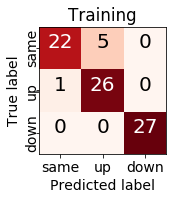

In [46]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter = 100000, class_weight='balanced')

# svm_pipe = Pipeline(steps=[('scale', scale), ('svm', svm)])
svm_pipe = Pipeline(steps=[('scale', scale), ('select1', select1), ('select2', select2), ('svm', svm)])
# svm_pipe = Pipeline(steps=[('scale', scale), ('ref', rfe), ('svm', svm)])

run_model_CV(svm_pipe, 'SVM')

In [ ]:
param_grid = {'svm__C': np.logspace(0.5, 2, 3)}

run_grid_search(svm_pipe, param_grid)

## K Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
# knn_pipe = Pipeline(steps=[('scale', scale), ('ref', rfe), ('knn', knn)])
knn_pipe = Pipeline(steps=[('scale', scale), ('select1', select1), ('select2', select2), ('knn', knn)])

run_model_CV(knn_pipe, 'KNN')

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='auto', solver='lbfgs')
# logreg_pipe = Pipeline(steps=[('scale', scale), ('ref', rfe), ('logreg', logreg)])
logreg_pipe = Pipeline(steps=[('scale', scale), ('select1', select1), ('select2', select2), ('logreg', logreg)])

run_model_CV(logreg_pipe, 'Log Reg')

## Kernel SVM

In [ ]:
from sklearn.svm import SVC

svm = SVC(gamma='auto')
svm_pipe = Pipeline(steps=[('scale', scale), ('select1', select1), ('select2', select2), ('svm', svm)])

run_model_CV(svm_pipe, 'Kernel SVM', score_test=True)

In [ ]:
param_grid = {'svm__C': np.logspace(-2, 4, 10),
              'svm__gamma': np.logspace(-6, 2, 10) / X_train.shape[0]}

run_grid_search(svm_pipe, param_grid, score_test=True)

## XGBoost

0.6172839506172839 0.1062015465066991
Default XGBoost CV score mean accuracy: 0.6173

21st-Century-Fox default XGBoost test score accuracy: 0.9839
['same', 'down']
{'same': 0, 'up': 1, 'down': 2}
true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pred:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]

AT&T default XGBoost test score accuracy: 0.0645
['same', 'down']
{'same': 0, 'up': 1, 'down': 2}
true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pred:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

CBS default XGBoost test score accuracy: 0.7258
['same', 'up', 'down']
{'same': 0, 'up': 1, 'down': 2}
true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

<Figure size 432x288 with 0 Axes>

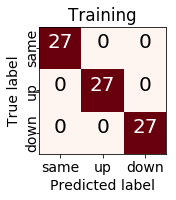

<Figure size 432x288 with 0 Axes>

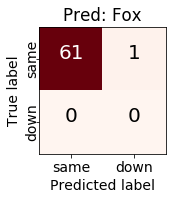

<Figure size 432x288 with 0 Axes>

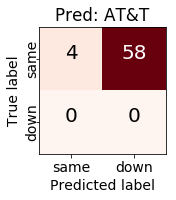

<Figure size 432x288 with 0 Axes>

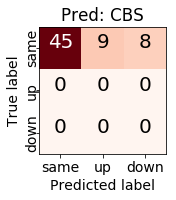

<Figure size 432x288 with 0 Axes>

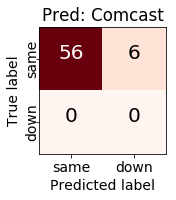

<Figure size 432x288 with 0 Axes>

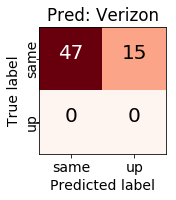

In [34]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb_pipe = Pipeline(steps=[('scale', scale), ('select1', select1), ('select2', select2), ('xgb', xgb)])
# xgb_pipe = Pipeline(steps=[('scale', scale), ('select1', select1), ('xgb', xgb)])

run_model_CV(xgb_pipe, 'XGBoost', score_test=True)

In [ ]:
importances = xgb_pipe.feature_importances_
features = list(df_train.columns)

df_imp = pd.DataFrame(columns=['feature', 'importance'])
df_imp['feature'] = features
df_imp['importance'] = importances

df_imp.sort_values(by='importance', axis=0, ascending=False, inplace=True)
# df_imp.reset_index(inplace=True)
df_imp
df_imp_top20 = df_imp.iloc[:20]
df_imp_top20.sort_values(by='importance', axis=0, ascending=True, inplace=True)

plt.figure()
df_imp_top20.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(6, 10))

plt.title('XGBoost Feature Importance - top 20')
plt.xlabel('importance')
plt.show()

## Random Forest

[0.62962963 0.48148148 0.77777778]
Default RF CV score mean accuracy: 0.6296

21st-Century-Fox default RF test score accuracy: 1.0000
['same']
{'same': 0, 'up': 1, 'down': 2}
true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pred:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

AT&T default RF test score accuracy: 0.4754
['same', 'down']
{'same': 0, 'up': 1, 'down': 2}
true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pred:  [2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2
 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

CBS default RF test score accuracy: 1.0000
['same']
{'same': 0, 'up': 1, 'down': 2}
true:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

<Figure size 432x288 with 0 Axes>

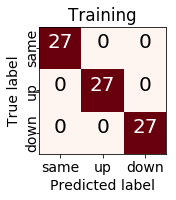

<Figure size 432x288 with 0 Axes>

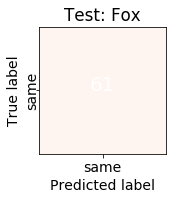

<Figure size 432x288 with 0 Axes>

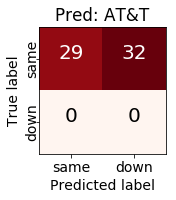

<Figure size 432x288 with 0 Axes>

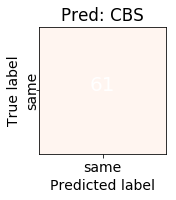

<Figure size 432x288 with 0 Axes>

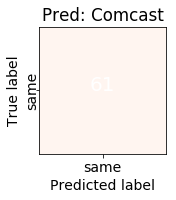

<Figure size 432x288 with 0 Axes>

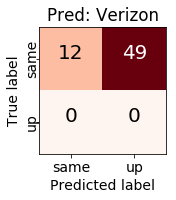

In [68]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=300)
rf_pipe = Pipeline(steps=[('scale', scale), ('select1', select1), ('select2', select2), ('rf', rf)])

run_model_CV(rf_pipe, 'RF', score_test=True)

In [ ]:
param_grid = {'rf__min_samples_split': [2,3,4,5]}

run_grid_search(rf_pipe, param_grid, score_test=True)

In [ ]:
importances = rf_pipe.steps[3][1].feature_importances_
features = list(df_train.columns)

df_imp = pd.DataFrame(columns=['feature', 'importance'])
df_imp['feature'] = features
df_imp['importance'] = importances

df_imp.sort_values(by='importance', axis=0, ascending=False, inplace=True)
# df_imp.reset_index(inplace=True)
df_imp
df_imp_top20 = df_imp.iloc[:20]
df_imp_top20.sort_values(by='importance', axis=0, ascending=True, inplace=True)

plt.figure()
df_imp_top20.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(6, 10))

plt.title('RF Feature Importance - top 20')
plt.xlabel('importance')
plt.show()

In [ ]:
for col in df_expand.columns:
    print(col)

In [ ]:
rf_pipe.steps[3][1].feature_importances_

In [ ]:
rf_pipe.steps[2][1]